In [1]:
#coding:utf-8
%matplotlib inline
#上面语句：使图片内嵌交互环境显示
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

In [2]:
# 科学计算用
import numpy as np
from pandas import Series,DataFrame
import pandas as pd

# 数据聚合与分组运算

对数据集进行分组并对各组应用一个函数（无论是聚合还是转换），这是数据分析工作中的重要环节。

在将数据集准备好之后，通常的任务就是计算分组统计或生成透视表

在本章中，你将会学到： 
- 根据一个或多个键（可以是函数、数组或DataFrame列名）拆分pandas对象。 
- 计算分组摘要统计，如计数、平均值、标准差，或用户自定义函数。 
- 对DataFrame的列应用各种各样的函数。 
- 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。 
- 计算透视表或交叉表。 
- 执行分位数分析以及其他分组分析。

## GroupBy技术

分组运算的第一个阶段，pandas对象（无论是Series、DataFrame还是其他的）中的数据会根据你所提供的一个或多个键被拆分（split）为多组。

拆分操作是在对象的特定轴上执行的。例如，DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。

然后，将一个函数应用（apply）到各个分组并产生一个新值。

最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。

结果对象的形式一般取决于数据上所执行的操作。

下图大致说明了一个简单的分组聚合过程。

<img src='pic\分组聚合演示.png' width=50%>

分组键可以有多种形式，且类型不必相同：

- 列表或数组，其长度与待分组的轴一样。

- 表示DataFrame某个列名的值。

- 字典或Series，给出待分组轴上的值与分组名之间的对应关系。

- 函数，用于处理轴索引或索引中的各个标签。

In [4]:
df=DataFrame({'key1':['a','a','b','b','a'],'key2':['one','two','one','two','one'],
              'data1':np.random.randn(5),'data2':np.random.randn(5)})
df

,data1,data2,key1,key2
0,1.142228,-0.695662,a,one
1,1.094609,0.065266,a,two
2,-0.836508,0.541420,b,one
3,-1.558866,1.907961,b,two
4,-0.365907,-0.189732,a,one


In [5]:
# 按key1进行分组，并计算data1列的平均值
grouped = df['data1'].groupby(df['key1']) # Series根据分组键Series产生了一个新的Series，其索引为key1列中的唯一值
grouped # grouped是一个GroupBy对象

In [6]:
# 调用方法来计算
grouped.mean()

key1
a    0.623644
b   -1.197687
Name: data1, dtype: float64

In [7]:
# 传入多个分组键
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means # 得到的Series具有一个层次化索引

key1  key2
a     one     0.388161
      two     1.094609
b     one    -0.836508
      two    -1.558866
Name: data1, dtype: float64

In [8]:
# 可以进行调换
means.unstack()

key2,one,two
key1,,
a,0.388161,1.094609
b,-0.836508,-1.558866


- 以上的例子中分组键都是Series。其实，分组键可以是任何长度适当的数组

In [9]:
states=np.array(['Ohio','California','California','Ohio','Ohio'])
years=np.array([2005,2005,2006,2005,2006])

In [10]:
df['data1'].groupby([states,years]).mean()

California  2005    1.094609
            2006   -0.836508
Ohio        2005   -0.208319
            2006   -0.365907
Name: data1, dtype: float64

- 可以使用列名的字符串、数字或其他Python对象用作分组键

In [11]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.623644,-0.273376
b,-1.197687,1.224691


In [12]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one   0.388161 -0.442697
     two   1.094609  0.065266
b    one  -0.836508  0.541420
     two  -1.558866  1.907961

- 注：再使用df.groupby('key1').mean()时，返回的结果中没有key2列，这是因为其并不是数值数据

In [13]:
# 返回分组大小
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 对分组进行迭代

In [14]:
# GroupBy对象支持迭代
for name,group in df.groupby('key1'):
    print(name)
    print(group)
    print('--------')

a
      data1     data2 key1 key2
0  1.142228 -0.695662    a  one
1  1.094609  0.065266    a  two
4 -0.365907 -0.189732    a  one
--------
b
      data1     data2 key1 key2
2 -0.836508  0.541420    b  one
3 -1.558866  1.907961    b  two
--------


In [15]:
# 多重键的情况
for (k1,k2),group in df.groupby(['key1','key2']):
    print(k1,k2)
    print(group)
    print('-------')

a one
      data1     data2 key1 key2
0  1.142228 -0.695662    a  one
4 -0.365907 -0.189732    a  one
-------
a two
      data1     data2 key1 key2
1  1.094609  0.065266    a  two
-------
b one
      data1    data2 key1 key2
2 -0.836508  0.54142    b  one
-------
b two
      data1     data2 key1 key2
3 -1.558866  1.907961    b  two
-------


In [16]:
# 将这些数据片段做成一个字典
pieces_list = list(df.groupby('key1'))
pieces_list

[('a',       data1     data2 key1 key2
  0  1.142228 -0.695662    a  one
  1  1.094609  0.065266    a  two
  4 -0.365907 -0.189732    a  one), ('b',       data1     data2 key1 key2
  2 -0.836508  0.541420    b  one
  3 -1.558866  1.907961    b  two)]

In [17]:
pieces = dict(pieces_list)
pieces

{'a':       data1     data2 key1 key2
 0  1.142228 -0.695662    a  one
 1  1.094609  0.065266    a  two
 4 -0.365907 -0.189732    a  one, 'b':       data1     data2 key1 key2
 2 -0.836508  0.541420    b  one
 3 -1.558866  1.907961    b  two}

In [18]:
# groupby默认是在axis=0上进行分组的,下面根据dtype对列进行分组
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [19]:
grouped = df.groupby(df.dtypes,axis=1) # 等于把df.dtypes作为第6行加入进去，然后 按这一行进行分组
dict(list(grouped))

{dtype('float64'):       data1     data2
 0  1.142228 -0.695662
 1  1.094609  0.065266
 2 -0.836508  0.541420
 3 -1.558866  1.907961
 4 -0.365907 -0.189732, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

In [20]:
grouped.size()

float64    2
object     2
dtype: int64

### 选取一个或一组列

In [21]:
# 对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的
df.groupby('key1')['data1']
df.groupby('key1')[['data1','data2']]

In [22]:
# 上面语句是下面这句的语法糖
df['data1'].groupby(df['key1'])
df[['data1','data2']].groupby(df['key1'])

In [23]:
# 对于大数据集，很可能只需要对部分列进行聚合。
# 例如，在前面那个数据集中，如果只需计算data2列的平均值并以DataFrame形式得到结果，我们可以编写
df.groupby(['key1','key2'])[['data2']].mean() # 返回的直接是DataFrame

data2
key1 key2          
a    one  -0.442697
     two   0.065266
b    one   0.541420
     two   1.907961

In [24]:
# 与之对应的另外一种取法：返回的不是DataFrame
grouped = df['data2'].groupby([df['key1'],df['key2']]).mean()
grouped

key1  key2
a     one    -0.442697
      two     0.065266
b     one     0.541420
      two     1.907961
Name: data2, dtype: float64

In [25]:
pd.DataFrame(grouped)

data2
key1 key2          
a    one  -0.442697
     two   0.065266
b    one   0.541420
     two   1.907961

### 通过字典或Series进行分组

In [26]:
people=DataFrame(np.random.randn(5,5),columns=['a','b','c','d','e'],
                index=['Joe','Steve','Wes','Jim','Travis'])
people.loc[2:3,['b','c']]=np.nan #添加NA值
people

,a,b,c,d,e
Joe,0.233659,2.194493,1.245105,-1.856778,-1.232374
Steve,-0.526099,0.538666,0.823842,0.544531,0.483280
Wes,-0.191683,NaN,NaN,-0.120436,-0.713844
Jim,1.702314,-0.441611,-0.363337,-0.023122,-1.298583
Travis,-1.843750,-1.779378,-0.419842,-1.062702,1.721818


In [27]:
# 假设已知分组关系，则可以自定义分组依据
mapping={'a':'red',
         'b':'red',
         'c':'blue',
         'd':'blue',
         'e':'red',
         'f':'orange'}

In [28]:
# 传入字典
by_columns = people.groupby(mapping,axis=1)
by_columns

In [29]:
by_columns.sum()

,blue,red
Joe,-0.611673,1.195779
Steve,1.368373,0.495846
Wes,-0.120436,-0.905526
Jim,-0.386458,-0.037879
Travis,-1.482544,-1.901310


In [30]:
# Series也有同样的功能，它可以被看做一个固定大小的映射。
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [31]:
people.groupby(map_series,axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 通过函数进行分组

In [32]:
# 任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。
people.groupby(len).sum()
# 具体点说，以上的示例DataFrame为例，其索引值为人的名字。
# 假设你希望根据人名的长度进行分组，虽然可以求取一个字符串长度数组，但其实仅仅传入len函数

,a,b,c,d,e
3,1.744291,1.752883,0.881768,-2.000336,-3.244800
5,-0.526099,0.538666,0.823842,0.544531,0.483280
6,-1.843750,-1.779378,-0.419842,-1.062702,1.721818


In [33]:
# 将函数跟数组、列表、字典、Series混合使用可以，因为任何东西最终都会被转换为数组
key_list = ['one','one','one','two','two']
people.groupby([len,key_list]).min()

a         b         c         d         e
3 one -0.191683  2.194493  1.245105 -1.856778 -1.232374
  two  1.702314 -0.441611 -0.363337 -0.023122 -1.298583
5 one -0.526099  0.538666  0.823842  0.544531  0.483280
6 two -1.843750 -1.779378 -0.419842 -1.062702  1.721818

### 根据索引级别分组

In [34]:
# 层次化索引数据集最方便的地方就在于它能够根据索引级别进行聚合。
# 通过level关键字传入级别编号或名称
columns = pd.MultiIndex.from_arrays([['US','US','US','JP','JP'],
                                     [1,3,5,1,3]],names=['cty','tenor'])
hier_df=DataFrame(np.random.randn(4,5),columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.369220 -0.076831 -1.378694  0.602127  0.665380
1     -0.774983 -0.593730  1.203471 -3.031213  0.398424
2     -1.302254 -1.030804  2.108959 -1.009281  1.926683
3     -0.625474  0.365835 -0.182251 -0.765682 -0.976158

In [35]:
hier_df.groupby(level = 'cty',axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 数据聚合

- 对于聚合，指的是任何能够从数组产生标量值的数据转换过程。 
- 使用自己发明的聚合运算，还可以调用分组对象上已经定义好的任何方法。

In [36]:
# 例如，quantile可以计算Series或DataFrame列的样本分位数
df=DataFrame({'key1':['a','a','b','b','a'],'key2':['one','two','one','two','one'],
              'data1':np.random.randn(5),'data2':np.random.randn(5)})
df

,data1,data2,key1,key2
0,0.499114,0.879262,a,one
1,0.231578,-0.399079,a,two
2,-1.144416,0.168831,b,one
3,-0.607877,0.151589,b,two
4,0.190478,-0.505882,a,one


In [37]:
grouped = df.groupby('key1')

In [38]:
grouped['data1'].quantile(0.9)

key1
a    0.445606
b   -0.661531
Name: data1, dtype: float64

- 注意：quantile并没有明确地实现与GroupBy，但是它是一个Series方法，所以这里是能用的。
- 实际上，GroupBy会高效地对Series进行切片，然后对各片调用piece.quantile(0.9)方法

In [39]:
# 可以使用自己的聚合函数，只需要传入aggregate或agg方法即可：
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped.agg(peak_to_peak)
#注意：自定义聚合函数要比那些经过优化的函数慢得多。这是因为在构造中间分组数据块时存在非常大的开销（函数调用、数据重排等）

,data1,data2
key1,,
a,0.308635,1.385144
b,0.536539,0.017243


In [40]:
# describe也可以使用，即使严格来讲，它们并非聚合运算
grouped.describe().stack()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.307057 -0.008566
     std    0.167591  0.770734
     min    0.190478 -0.505882
     25%    0.211028 -0.452480
     50%    0.231578 -0.399079
     75%    0.365346  0.240092
     max    0.499114  0.879262
b    count  2.000000  2.000000
     mean  -0.876146  0.160210
     std    0.379391  0.012192
     min   -1.144416  0.151589
     25%   -1.010281  0.155899
     50%   -0.876146  0.160210
     75%   -0.742012  0.164521
     max   -0.607877  0.168831

<img src='pic\经过优化的GroupBy的方法.png' width=50%>

### 更高级的聚合功能（准备工作）

In [42]:
tips = pd.read_csv(r'ch09\tips.csv')

In [43]:
#添加“小费占总额百分比”的列
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [44]:
tips[:5]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


### 面向列的多函数应用

In [45]:
# 使用sex和smoker对tips进行分组
grouped = tips.groupby(['sex','smoker'])

In [46]:
# 对于经优化过的方法，可以将函数名已字符串的形式传入
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [47]:
# 传入一组函数
grouped_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [48]:
# 修改自动列命名
grouped_pct.agg([(u'平均值','mean'),(u'标准差',np.std)])

平均值       标准差
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

In [49]:
# 定义一组应用于全部列的函数，或不同的列应用不同的函数
functions = ['count','mean','max'] # 也可以用[('最大值',np.max)('平均值','mean')]来重命名
result = grouped['tip_pct','total_bill'].agg(functions)

In [50]:
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [51]:
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

In [52]:
# 不同的列应用不同的函数
grouped.agg({'tip':[np.max,'max','min'],'size':'sum'})

tip             size
               amax   max   min  sum
sex    smoker                       
Female No       5.2   5.2  1.00  140
       Yes      6.5   6.5  1.00   74
Male   No       9.0   9.0  1.25  263
       Yes     10.0  10.0  1.00  150

In [53]:
# 以“无索引”的形式返回聚合数据，设置as_index = False
tips.groupby(['sex','smoker'],as_index = False).mean()
# 对结果调用reset_index也能得到这种形式的结果

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


## 分组级运算和转换

- 聚合是分组运算的其中一种。它是数据转换的一个特例，它接受能够将一维数组简化为标量值的函数。

- 接下来将介绍transform和apply方法，它们能够执行更多其他的分组运算。

In [54]:
# 如果要为一个DataFrame添加一个用于存放各索引分组平均值的列。一个办法是先聚合再合并
df

,data1,data2,key1,key2
0,0.499114,0.879262,a,one
1,0.231578,-0.399079,a,two
2,-1.144416,0.168831,b,one
3,-0.607877,0.151589,b,two
4,0.190478,-0.505882,a,one


In [55]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.307057,-0.008566
b,-0.876146,0.160210


In [56]:
pd.merge(df,k1_means,left_on='key1',right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,0.499114,0.879262,a,one,0.307057,-0.008566
1,0.231578,-0.399079,a,two,0.307057,-0.008566
4,0.190478,-0.505882,a,one,0.307057,-0.008566
2,-1.144416,0.168831,b,one,-0.876146,0.160210
3,-0.607877,0.151589,b,two,-0.876146,0.160210


In [57]:
# 上面不太灵活。下面是一种灵活的方式：该过程看做利用np.mean函数对两个数据列进行转换,我们将在GroupBy上使用transform方法
key = ['one','two','one','two','one']
people

,a,b,c,d,e
Joe,0.233659,2.194493,1.245105,-1.856778,-1.232374
Steve,-0.526099,0.538666,0.823842,0.544531,0.483280
Wes,-0.191683,NaN,NaN,-0.120436,-0.713844
Jim,1.702314,-0.441611,-0.363337,-0.023122,-1.298583
Travis,-1.843750,-1.779378,-0.419842,-1.062702,1.721818


In [58]:
people.groupby(key).mean()

,a,b,c,d,e
one,-0.600591,0.207558,0.412631,-1.013305,-0.074800
two,0.588107,0.048528,0.230253,0.260705,-0.407651


In [59]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.600591,0.207558,0.412631,-1.013305,-0.074800
Steve,0.588107,0.048528,0.230253,0.260705,-0.407651
Wes,-0.600591,0.207558,0.412631,-1.013305,-0.074800
Jim,0.588107,0.048528,0.230253,0.260705,-0.407651
Travis,-0.600591,0.207558,0.412631,-1.013305,-0.074800


- transform会将一个函数应用到各个分组，然后将结果放置到适当的位置上。如果各分组产生的是一个标量值，则该值就会被广播出去。

In [60]:
# 我们先创建一个距平化函数（demeaning function），然后将其传给transform
def demean(arr):
    return arr - arr.mean()

In [61]:
demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,0.834251,1.986935,0.832473,-0.843472,-1.157574
Steve,-1.114207,0.490138,0.593589,0.283827,0.890931
Wes,0.408908,NaN,NaN,0.892869,-0.639044
Jim,1.114207,-0.490138,-0.593589,-0.283827,-0.890931
Travis,-1.243159,-1.986935,-0.832473,-0.049397,1.796618


In [62]:
# 距平化之后得到的函数，平均值为0
demeaned.groupby(key).mean()

,a,b,c,d,e
one,7.401487e-17,0.0,-5.551115e-17,-3.700743e-17,7.401487e-17
two,1.110223e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00


### apply：一般性的“拆分-应用-合并”

跟aggregate一样，transform也是一个有着严格条件的特殊函数，传入的函数只能产生两种结果，
    - 要么产生一个可以广播的标量值（如np.mean）
    - 要么产生一个相同大小的结果数组。

最一般化的GroupBy方法是apply。

In [63]:
# 回到之前那个小费数据集，假设你想要根据分组选出最高的5个tip_pct值。首先，编写一个选取指定列具有最大值的行的函数
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [64]:
top(tips,n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [65]:
# 现在对smoker分组，并用该函数调用apply
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

- top函数在DataFrame的各个片段上调用，然后结果由pandas.concat组装到一起，并以分组名称进行了标记。
- 于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。

In [66]:
# 可以为函数传入参数
tips.groupby(['smoker','day']).apply(top,n=1,column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

In [67]:
# 之前在GroupBy对象上调用过describe
result = tips.groupby('smoker')['tip_pct'].describe()
result.stack()

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
dtype: float64

In [68]:
# 实际上执行的语句是：
f = lambda x:x.describe()
tips.groupby('smoker')['tip_pct'].apply(f)

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

#### 禁止分组键

In [69]:
tips.groupby('smoker',group_keys = False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### 分位数和桶分析

In [70]:
# pandas根据指定面元或样本分位数将数据拆分成多块的工具（cut、qcut）
frame = DataFrame({'data1':np.random.randn(1000),'data2':np.random.randn(1000)})
frame['data1'][:10]

0   -0.738961
1   -0.816859
2   -1.277964
3    0.610274
4    2.108654
5    0.741024
6   -0.090033
7    0.078206
8    1.299888
9    1.172683
Name: data1, dtype: float64

In [71]:
factor = pd.cut(frame.data1,4) # 返回的是，每一个数，位于4组（长度相等）中的那一种。
factor[:10]

0    (-2.094, -0.303]
1    (-2.094, -0.303]
2    (-2.094, -0.303]
3     (-0.303, 1.488]
4      (1.488, 3.279]
5     (-0.303, 1.488]
6     (-0.303, 1.488]
7     (-0.303, 1.488]
8     (-0.303, 1.488]
9     (-0.303, 1.488]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.892, -2.094] < (-2.094, -0.303] < (-0.303, 1.488] < (1.488, 3.279]]

In [72]:
# 由cut返回的Factor对象可直接用于groupby
def get_stats(group):
    return {u'最小值':group.min(),u'最大值':group.max(),
           u'数量':group.count(),u'平均值':group.mean()}

In [73]:
grouped = frame.data2.groupby(factor)

In [74]:
grouped.apply(get_stats).unstack()

,平均值,数量,最大值,最小值
data1,,,,
"(-3.892, -2.094]",-0.084110,17.0,1.571175,-1.668280
"(-2.094, -0.303]",0.013307,371.0,3.892919,-2.425039
"(-0.303, 1.488]",-0.017110,529.0,2.840233,-2.859379
"(1.488, 3.279]",0.161753,83.0,2.028844,-2.262007


In [75]:
# 利用qcut取得大小相同的桶
grouping = pd.qcut(frame.data1,10,labels=False)

In [76]:
grouped = frame.data2.groupby(grouping)

In [77]:
grouped.apply(get_stats).unstack()

,平均值,数量,最大值,最小值
data1,,,,
0,0.118600,100.0,3.892919,-2.341325
1,-0.181843,100.0,1.969632,-2.425039
2,-0.027487,100.0,2.250289,-1.912214
3,0.111859,100.0,1.877791,-2.155642
4,-0.127262,100.0,2.840233,-2.559810
5,-0.013525,100.0,2.079716,-2.044826
6,0.113264,100.0,2.662486,-2.859379
7,-0.052884,100.0,2.146777,-2.526068
8,0.024052,100.0,2.695064,-2.245913


### 示例-1：用特定于分组的值填充缺失值

In [78]:
# 用平均值去填充NA值
s = Series(np.random.randn(6))

In [79]:
s[::2] = np.nan
s

0         NaN
1   -1.565646
2         NaN
3   -1.341833
4         NaN
5   -0.291519
dtype: float64

In [80]:
s.fillna(s.mean())

0   -1.066333
1   -1.565646
2   -1.066333
3   -1.341833
4   -1.066333
5   -0.291519
dtype: float64

In [81]:
# 对于不同的分组，填充不同的值
states=['Ohio','New York','Vermont','Florida','Oregon','Nevada','California','Idaho']

In [82]:
group_key=['East']*4+['West']*4

In [83]:
data=Series(np.random.randn(8),index=states)

In [84]:
data[['Vermont','Nevada','Idaho']]=np.nan
data

Ohio         -2.449351
New York      0.522157
Vermont            NaN
Florida      -2.300568
Oregon       -1.741848
Nevada             NaN
California    1.488795
Idaho              NaN
dtype: float64

In [85]:
data.groupby(group_key).mean()

East   -1.409254
West   -0.126526
dtype: float64

In [86]:
fill_mean = lambda g:g.fillna(g.mean())

In [87]:
data.groupby(group_key).apply(fill_mean)

Ohio         -2.449351
New York      0.522157
Vermont      -1.409254
Florida      -2.300568
Oregon       -1.741848
Nevada       -0.126526
California    1.488795
Idaho        -0.126526
dtype: float64

In [88]:
# 可以预定义各组的填充值（利用分组有name属性）
fill_values = {'East':0.5,'West':-1}

In [89]:
fill_func = lambda g:g.fillna(fill_values[g.name])

In [90]:
data.groupby(group_key).apply(fill_func)

Ohio         -2.449351
New York      0.522157
Vermont       0.500000
Florida      -2.300568
Oregon       -1.741848
Nevada       -1.000000
California    1.488795
Idaho        -1.000000
dtype: float64

### 示例-2：随机采样和排列

从一个大数据集中随机抽取样本进行分析工作，方式有很多，其中一些的效率会比其他的高很多。

一个办法是，选取np.random.permutation(N)的前K个元素，其中N为完整数据的大小，K为期望的样本大小。

In [91]:
# 红桃（Hearts）、黑桃（Spades）、梅花（Clubs）、方片（Diamonds）
suits = [u'红桃',u'黑桃',u'梅花',u'方片']

In [92]:
card_val = (list(range(1,11)) + [10]*3) *4
card_val[:15]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2]

In [93]:
base_names = ['A'] + list(range(2,11)) + ['J','Q','K']
base_names

['A', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'Q', 'K']

In [94]:
cards = []
for suit in suits:
    cards.extend(suit + str(num) for num in base_names)
cards[:10]

['红桃A', '红桃2', '红桃3', '红桃4', '红桃5', '红桃6', '红桃7', '红桃8', '红桃9', '红桃10']

In [95]:
deck = Series(card_val,index=cards)
deck[:15]

红桃A      1
红桃2      2
红桃3      3
红桃4      4
红桃5      5
红桃6      6
红桃7      7
红桃8      8
红桃9      9
红桃10    10
红桃J     10
红桃Q     10
红桃K     10
黑桃A      1
黑桃2      2
dtype: int64

In [96]:
# 从整副牌中抽出5张：
def draw(deck,n=5):
    return deck.take(np.random.permutation(len(deck))[:n])

In [97]:
draw(deck)

黑桃3     3
红桃4     4
方片3     3
红桃J    10
红桃5     5
dtype: int64

In [98]:
# 从每种花色中随机抽取两张牌
get_suit = lambda card:card[:2]

In [99]:
deck.groupby(get_suit,group_keys=False).apply(draw,n=2)

方片9     9
方片5     5
梅花3     3
梅花Q    10
红桃6     6
红桃J    10
黑桃K    10
黑桃5     5
dtype: int64

### 示例-3：分组加权平均数和相关关系

In [100]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',  'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

,category,data,weights
0,a,0.056258,0.666916
1,a,1.695492,0.376938
2,a,-0.634811,0.646772
3,a,-0.173510,0.658200
4,b,0.567174,0.686041
5,b,0.052852,0.093045
6,b,-0.217590,0.773713
7,b,-0.625070,0.769875


In [101]:
grouped = df.groupby('category')

In [102]:
# 计算加权平均数，weights=权重
get_wavg = lambda g:np.average(g['data'],weights = g['weights'])

In [103]:
grouped.apply(get_wavg)

category
a    0.064642
b   -0.110027
dtype: float64

In [104]:
# 稍微实际点的例子：来自Yahoo!Finance的数据集，其中含有标准普尔500指数（SPX字段）和几只股票的收盘价
close_px = pd.read_csv('ch09\stock_px.csv',parse_dates=True,index_col=0)
close_px[:5]

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


In [105]:
# 计算一个由日收益率（通过百分数变化计算）与SPX之间的年度相关系数组成的DataFrame。下面是一个实现办法
rets = close_px.pct_change().dropna()
# pct_change()：计算百分比变化

In [106]:
spx_corr = lambda x: x.corrwith(x['SPX']) # cov计算协方差； corrwith计算相关系数；

In [107]:
by_year = rets.groupby(lambda x:x.year)

In [108]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [109]:
# 计算列与列之间的相关系数：
by_year.apply(lambda g : g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

In [110]:
# 插一个例子
by_year.apply(lambda g : g.mean())

,AAPL,MSFT,XOM,SPX
2003,0.001736,0.000275,0.000748,0.000859
2004,0.004700,0.000404,0.001029,0.000366
2005,0.003490,0.000004,0.000549,0.000138
2006,0.000949,0.000672,0.001388,0.000529
2007,0.003664,0.000858,0.000979,0.000189
2008,-0.002646,-0.001859,-0.000035,-0.001587
2009,0.003819,0.002152,-0.000401,0.000983
2010,0.001832,-0.000172,0.000447,0.000542
2011,0.001487,0.000090,0.000548,-0.000033


In [111]:
# 插一个例子
by_year.apply(lambda g : g['AAPL'].mean())

2003    0.001736
2004    0.004700
2005    0.003490
2006    0.000949
2007    0.003664
2008   -0.002646
2009    0.003819
2010    0.001832
2011    0.001487
dtype: float64

### 示例-4：面向分组的线性回归

In [112]:
# 可以用groupby执行更为复杂的分组统计分析，只要函数返回的是pandas对象或标量值即可
# 例如，可以定义下面这个regress函数（利用statsmodels库）对各数据块执行普通最小二乘法（Ordinary Least Squares，OLS）回归
import statsmodels.api as sm
def regress(data,yvar,xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1
    result = sm.OLS(Y,X).fit()
    return result.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [113]:
by_year.apply(regress,'AAPL',['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 透视表和交叉表

- 在Python和pandas中，可以通过本章所介绍的groupby功能以及（能够利用层次化索引的）重塑运算制作透视表。
- DataFrame有一个pivot_table方法，此外还有一个顶级的pandas.pivot_table函数。
- 除能为groupby提供便利之外，pivot_table还可以添加分项小计（也叫做margins）。

In [114]:
# 回到小费数据集，根据sex和smoker计算分组平均数（pivot_table的默认聚合类型），并将sex和smoker放到行上
tips.pivot_table(index=['sex','smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [115]:
# 现在，假设我们只想聚合tip_pct和size，而且想根据day进行分组。我将smoker放到列上，把day放到行上
tips.pivot_table(['tip_pct','size'],index=['sex','day'],columns=['smoker'])

size             tip_pct          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   2.500000  2.000000  0.165296  0.209129
       Sat   2.307692  2.200000  0.147993  0.163817
       Sun   3.071429  2.500000  0.165710  0.237075
       Thur  2.480000  2.428571  0.155971  0.163073
Male   Fri   2.000000  2.125000  0.138005  0.144730
       Sat   2.656250  2.629630  0.162132  0.139067
       Sun   2.883721  2.600000  0.158291  0.173964
       Thur  2.500000  2.300000  0.165706  0.164417

In [116]:
# 传入margins=True添加分项小计。
tips.pivot_table(['tip_pct','size'],
                 index=['sex','day'],columns=['smoker'],
                margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   2.500000  2.000000  2.111111  0.165296  0.209129  0.199388
       Sat   2.307692  2.200000  2.250000  0.147993  0.163817  0.156470
       Sun   3.071429  2.500000  2.944444  0.165710  0.237075  0.181569
       Thur  2.480000  2.428571  2.468750  0.155971  0.163073  0.157525
Male   Fri   2.000000  2.125000  2.100000  0.138005  0.144730  0.143385
       Sat   2.656250  2.629630  2.644068  0.162132  0.139067  0.151577
       Sun   2.883721  2.600000  2.810345  0.158291  0.173964  0.162344
       Thur  2.500000  2.300000  2.433333  0.165706  0.164417  0.165276
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [117]:
# 要使用其他的聚合函数，将其传给aggfunc即可。
# 例如，使用len可以得到有关分组大小的交叉表
tips.pivot_table(['tip_pct'],
                 index=['sex','smoker'],columns=['day'],
                 aggfunc=len,
                 margins=True)

tip_pct                         
day               Fri   Sat   Sun  Thur    All
sex    smoker                                 
Female No         2.0  13.0  14.0  25.0   54.0
       Yes        7.0  15.0   4.0   7.0   33.0
Male   No         2.0  32.0  43.0  20.0   97.0
       Yes        8.0  27.0  15.0  10.0   60.0
All              19.0  87.0  76.0  62.0  244.0

In [118]:
# 如果存在空的组合（也就是NA），你可能会希望设置一个fill_value
tips.pivot_table('size',
                 index=['time','sex','smoker'],columns='day',
                 aggfunc=sum,
                 fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

In [119]:
%%html
<img src='pic\pivot_table的参数.png' width = 60%>

### 交叉表：crosstab

In [120]:
# 交叉表是一种用于计算分组频率的特殊透视表
pd.crosstab([tips.time,tips.day],tips.smoker,margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 示例：2012联邦选举委员会数据库

In [121]:
fec = pd.read_csv('ch09\P00000001-ALL.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


In [123]:
fec.loc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [124]:
# 该数据中没有党派信息, 所以最好把它加进来. 通过unique, 你可以获取全部候选人名单:
unique_cands = fec.cand_nm.unique()

In [125]:
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [126]:
# 利用字典说明党派关系
parties = {
    'Bachmann, Michelle': 'Republican',
    'Cain, Herman': 'Republican',
    'Gingrich, Newt': 'Republican',
    'Huntsman, Jon': 'Republican',
    'Johnson, Gary Earl': 'Republican',
    'McCotter, Thaddeus G': 'Republican',
    'Obama, Barack': 'Democrat',
    'Paul, Ron': 'Republican',
    'Pawlenty, Timothy': 'Republican',
    'Perry, Rick': 'Republican',
    "Roemer, Charles E. 'Buddy' III": 'Republican',
    'Romney, Mitt': 'Republican',
    'Santorum, Rick': 'Republican'
}

In [127]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [128]:
# 通过映射关系以及Series对象的map方法, 根据候选人姓名得到一组党派信息
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [129]:
# 将其添加为新列
fec['party'] = fec.cand_nm.map(parties)

In [130]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [131]:
# 注意: 该数据集既包括赞助也包括退款(负的出资)
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [132]:
# 简化过程, 过滤负的出资
fec = fec[fec.contb_receipt_amt > 0]

In [133]:
# 由于Obama和Romney是主要的2个候选人, 所以准备一个子集, 只包含针对2人的竞选活动的赞助信息
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### 根据职业和雇主统计赞助信息

In [134]:
# 基于职业的赞助信息统计是另一种经常被研究的统计任务. 比如, 律师更倾向于资助民主党, 而企业主更倾向于共和党:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [135]:
# 许多职业都设计相同的基本工作类型, 或同一样东西有多种变体. 
# 下面的代码可以清理一些这样的数据. 注意: 这里应用了dict.get, 它允许没有映射关系的职业也能"通过":
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

In [136]:
# 如果没有提供相关映射, 则返回x
f = lambda x: occ_mapping.get(x, x)

In [137]:
fec.loc[:,'contbr_employer'] = fec['contbr_employer'].map(f)

In [138]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,NOT PROVIDED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


In [139]:
# 通过pivot_table根据党派和职业对数据进行聚合, 然后过滤掉总出资额不足200W的数据
by_occupation = fec.pivot_table('contb_receipt_amt', index='contbr_occupation', columns='party', aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]

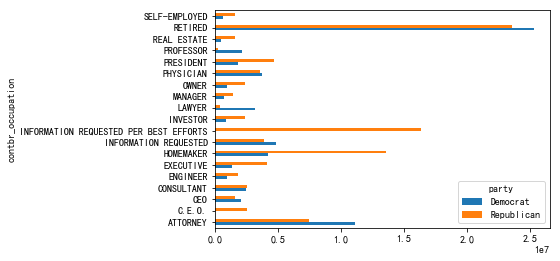

In [140]:
# 作图
over_2mm.plot(kind='barh')

In [141]:
# 想了解一下对Obama和Romney总出资额最高的职业和企业. 为此, 先对候选人进行分组, 然后使用本章前面介绍的求取最大值的方法:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # 根据key对totals进行降序排列
    return totals.sort_values(ascending=False)[:n]

In [142]:
# 然后根据职业和雇主进行聚合
grouped = fec_mrbo.groupby('cand_nm')

In [143]:
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [144]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

### 对出资额分组

In [145]:
# 还可以对该数据做另一种非常使用的分析: 利用cut函数根据出资额的大小将数据离散化到多个面元中
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)

In [146]:
# 然后根据候选人姓名以及面元标签对数据进行分组
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [147]:
# 从上面的数据可以看出, 在小额赞助方面, Obama获得的数量比Romney多很多. 
# 还可以对出资额求和并在面元内规范化, 以便图形化显示两位候选人各种赞助额度的比例:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)

In [148]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)

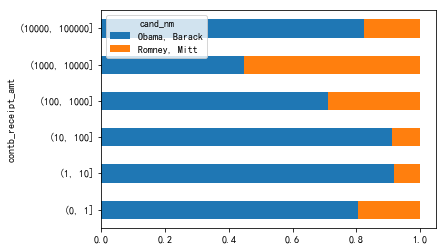

In [149]:
normed_sums[:-2].plot(kind='barh', stacked=True)

### 根据州统计赞助信息

In [150]:
# 首先是根据候选人和州对数据进行聚合
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])

In [151]:
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)

In [152]:
totals = totals[totals.sum(1) > 100000]

In [153]:
# 得到各候选人在各州的总额赞助比例
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
